<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Alison Cortesi / Germain Lefebvre / Florent Morin / Vincent Bilger</center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

* [0 - Importation des ressources](#chapter0)
    * [Important : Définition de la classe "Series"](#chapter0.important)


* [I - Préparation de notre data set pour la simulation](#chapter1)
    * [I.1 - Conversion des données en rendements logarithmiques](#chapter1.1)
    * [Complément : Modélisation d'une portefeuille d'actions pondéré](#chapter1.complement)
    * [I.2 - Split de notre data set](#chapter1.2)
    
    
* [II - Modélisation paramétrique](#chapter2)
    * [II.1  Modèle GARCH(p,q)](#chapter2.section1)
    * [II.2 - Simulations grâce à notre modèle GARCH(p,q)](#chapter2.section2)

        
* [III- Bootstrapping](#chapter3)


* [IV - Filtred Historical Simulation ](#chapter4)


* [V - Fonction de performance](#chapter5) 
    * [V.1 - Fonctions de mesures](#chapter5.section1)
    * [V.2 - Fonction Describe](#chapter5.section2)
    * [V.3 - Comparaison des prévisions par boostrapping, par FHS et GARCH(p,q)](#chapter5.section3)




## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [3]:
# conda install -c saravji pmdarima
# conda install -c conda-forge statsmodels

import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section
import datetime                                           #Used in section 0
from datetime import date                                 #Used in section 0
from statsmodels.tsa.arima_model import ARIMA             #Used in section 3.1.1
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pmdarima as pm                                     #Used in section 3.1.1              
#from pmdarima.arima import ARIMA                          #Used in section 3.1.1
from statsmodels.graphics.tsaplots import plot_acf        #Used in section 3.1.2 et 3.1.3
from arch import arch_model                               #Used in section 3.1.2 et 3.1.3
import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')
from scipy import stats                                   #Used in section 6.1
from scipy.stats import f_oneway                          #Used in section 6.1 
from scipy.stats import mannwhitneyu                      #Used in section 6.1
from scipy.stats import wasserstein_distance              #Used in section 6.1
from scipy.stats import wilcoxon                          #Used in section 6.1 

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [4]:
# root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/'                         #Germain
#root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
# root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
# root_path = 'C:/Users/alisoncortesi/Desktop/ECM_3A/OPT_DDEFI/TC_PROJDDEFI                         #Alison
# root_path = 'D:/Utilisateurs/JLEQ/BP2S/Datas/'                                                    #Julien                                                          #Julien

Importation de nos 3 bases d'indices afin de pouvoir selectionner les données souhaitées.

In [5]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')
Taux = pd.read_csv(root_path+'BDD_Rates.csv')
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')

Actions['Date'] = pd.to_datetime(Actions['Date'])
Actions = Actions.set_index(keys = 'Date', drop = True)

Taux['Date'] = pd.to_datetime(Taux['Date'])
Taux = Taux.set_index(keys = 'Date', drop = True)

Echanges['Date'] = pd.to_datetime(Echanges['Date'])
Echanges = Echanges.set_index(keys = 'Date', drop = True)

Afin de mieux visualiser les données à notre disposition, nous commençons par tracer l'évolution temporelle de nos données brutes.

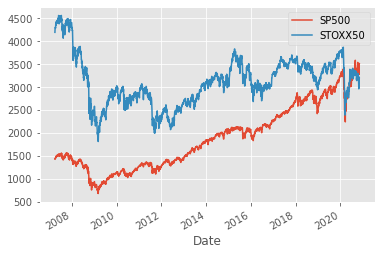

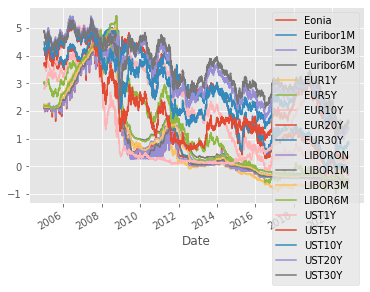

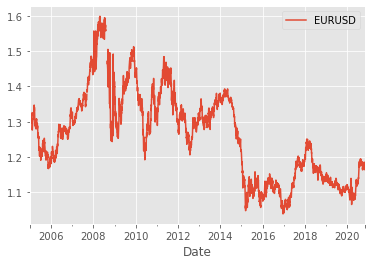

In [6]:
Actions.plot()
Taux.plot()
Echanges.plot()

Afin de pouvoir étudier un panel important de données, et notamment des taux, nous importons ici un grand nombre de fichier.
Dans un premier temps, toutes les données importées ne seront pas utilisées.
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 

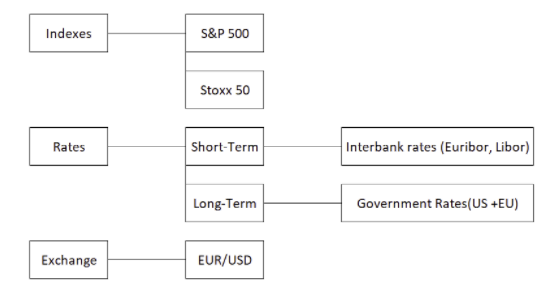

### <u> Important </u> : Définition de la classe "Series"  <a class="anchor" id="chapter0.important"></a>

In [151]:
class Series:
    
    def __init__(self, name, values, type_serie):
        self.name = name # nom de la série
        self.values = values # dataframe des valeurs
        self.type_serie = type_serie
    
    # Fonction qui plot les données
    def visualization(self):
        plt.plot(self.values)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Evolution of ' + self.name)
    
    # Fonction qui plot et retourne le tableau des valeurs des rendements
    def returns(self):
        if self.type_serie == "Action":
            var_pct = self.values.pct_change().dropna()
            ret = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            ret = self.values.diff().dropna()
        plt.plot(ret)
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title('Daily Logarithmic Returns for ' + self.name)
        return(ret)
    
    # Fonction qui renvoie la partie "training" du dataset
    def training(self):
        ret = self.returns()
        plt.close()
        T=int(np.floor(len(ret.index)*0.8))
        return(ret[0:T-1])
    
    # Fonction qui renvoie la partie "testing" du dataset
    def testing(self):
        ret = self.returns()
        plt.close()
        T=int(np.floor(len(ret.index)*0.8))
        return(ret[T:])
    
    # Fonction qui fit et renvoie un modèle Garch optimal pour les rendements de la série
    def garch(self, pmax, qmax):
        training_data = self.training()
        best_pq=[0,0]
        AIC = 0
        for p in range(1,pmax+1):
            for q in range(qmax+1):
                model = arch_model(training_data,p=p,q=q,rescale=False)
                fit = model.fit(update_freq=5,disp='off')
                if fit.aic<AIC:
                    AIC = fit.aic
                    best_pq[0]=p
                    best_pq[1]=q
        model = arch_model(training_data.iloc[:,0], vol='garch', p=best_pq[0], o=0, q=best_pq[1], rescale=True)
        fit = model.fit(update_freq=5,disp='off')
        return(best_pq,fit)
    
    
    # Fonction de prédiction paramétrique des returns (à revoir)
    def garch_modelisation(self, pmax, qmax):
        training_data=self.training()
        testing_data=self.testing()
        best_pq , fit = self.garch(pmax,qmax)
        forecasts = fit.forecast(horizon=len(testing_data))
        volatility = forecasts.variance.dropna().T**(1/2)
        mean = forecasts.mean.dropna().T
        pred = mean + volatility
        pred.index=testing_data.index
        plt.plot(testing_data, c='k',label='Real data')
        plt.plot(pred, c='r',label='Predicted data')
        plt.title('Rendements prédits par processus GARCH')
        plt.legend()
        
    # Fonction qui utilise la méthode HS (simple bootstrap) pour prédire les rendements/prix
    def historical_simulation(self,nb_paths):
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[len(training_data)-1])
        bootstrapped_returns = pd.DataFrame([random.choices(list(training_data.iloc[:,0]), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
    
    
    # Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés, avec GARCH pour le calcul de la vol.) pour prédire les rendements/prix    
    def filtered_historical_simulation_GARCH(self,nb_paths):  
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[len(training_data)-1])
        best_pq,model = self.garch(5,5)
        volatility = model.conditional_volatility
        standardized_returns = training_data.iloc[:,0]/volatility
        
        bootstrapped_returns = pd.DataFrame([random.choices(list(standardized_returns), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements standardisés bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
       
    # Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés, avec fenêtre glissante pour le calcul de la vol.) pour prédire les rendements/prix    
    def filtered_historical_simulation_glissant(self,nb_paths,len_fenetre):  
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[len(training_data)-1])
        best_pq, model = self.garch(5,5)
        volatility_garch = model.conditional_volatility
        
        #Fenetre glissante
        vol_glissant = []
        for i in range(len_fenetre):
            vol_glissant.append(volatility_garch[i])
        for i in range(len_fenetre, len(training_data)):    
            calc_vol = 100*training_data[self.name][i-len_fenetre:i].std(axis=0)
            vol_glissant.append(calc_vol)
        
        std_returns = []
        for i in range(len(training_data)):
            std_returns.append(training_data[self.name][i]/vol_glissant[i])
        standardized_returns = pd.DataFrame(std_returns, index = training_data.index)
        standardized_returns = standardized_returns[0] #Prend la bonne colonne 
        
        bootstrapped_returns = pd.DataFrame([random.choices(list(standardized_returns), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements standardisés bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
           
    # Fonction qui compare les résultats de nos différentes méthodes
    def describe(self):
        simulated_data_HS=self.historical_simulation(1000)
        plt.close()
        simulated_data_FHS=self.filtered_historical_simulation_GARCH(1000)
        plt.close()
        simulated_data_FHS_glissant=self.filtered_historical_simulation_glissant(1000,20)
        plt.close()
        testing_data = self.testing()
        plt.close()
        plt.clf()
        Data = pd.DataFrame({'Testing Set' : list(self.testing().iloc[:,0]), 'Simulated Data HS' : list(simulated_data_HS),'Simulated Data FHS GARCH' : list(simulated_data_FHS), 'Simulated Data FHS glissant' : list(simulated_data_FHS_glissant)},  index=testing_data.index)
        
        res = Data.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res.loc['Median Absolute Deviation'] = Median_Abs_dev(Data) #Add MAD measurement to the recap table
        res.loc['skew'] = skewness(Data)                                   #Add skew measurement to the recap table
        res.loc['kurtosis'] = kurtosis(Data)                               #Add kurtosis measurement to the recap table
        
        # Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data.columns) > 1 : 
            res.loc['Wasserstein Distance'] = Wasserstein(Data)
            res.loc['Wilcoxon Test'] = Wilcoxon(Data)[0]
            res.loc['Wilcoxon p-value'] = Wilcoxon(Data)[1]
            res.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data)[0]
            res.loc['Mann-Whitneyu p-value'] = Mann_Whitneyu(Data)[1]
            res.loc['F_test'] = F_test(Data)[0]
            res.loc['F_test p-value'] = F_test(Data)[1]
            res.loc['t_test'] = t_score(Data)[0]
            res.loc['t_test p-value'] = t_score(Data)[1] 
            res.loc['Z_test'] = Z_score(Data)[0]
            res.loc['Z_test p-value'] = Z_score(Data)[1]
        return res

Commençons par choisir une série de données à étudier.

In [152]:
serie = Series("EUR1Y", Taux[['EUR1Y']], "Taux")

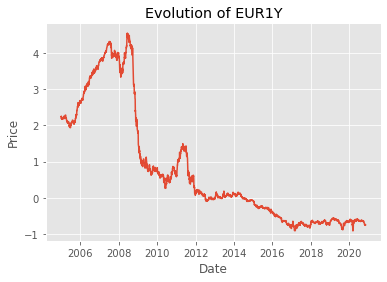

In [9]:
serie.visualization()

On peut maintenant afficher le rendement logarithmique journalier de notre série.

## I - Préparation de notre data set pour la simulation <a class="anchor" id="chapter1"></a>

[Retour Sommaire](#sommaire)

#### I.1 - Conversion des données en rendements logarithmiques <a class="anchor" id="chapter1.1"></a>


,EUR1Y
Date,
2005-01-04,-0.007800
2005-01-05,0.016197
2005-01-06,-0.040691
2005-01-07,-0.019599
2005-01-10,-0.008058
...,...
2020-11-02,-0.005953
2020-11-03,0.005633
2020-11-04,-0.005560


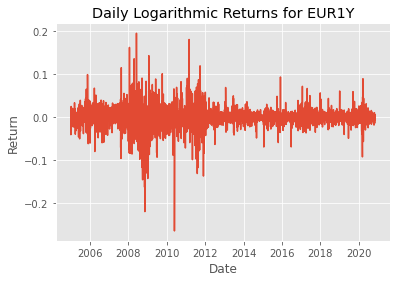

In [10]:
serie.returns()

<u>Remarque:</u> On voit bien les fortes varations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

#### I.2 - Split de notre dataset <a class="anchor" id="chapter1.2"></a>

[Retour Sommaire](#sommaire)

On sépare ensuite notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

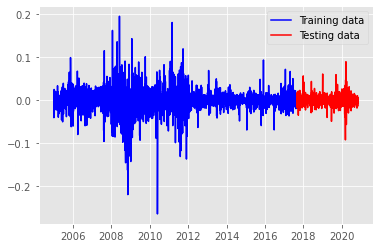

In [11]:
training_data = serie.training()
testing_data = serie.testing()
plt.plot(training_data,c='b',label='Training data')
plt.plot(testing_data,c='r',label='Testing data')
plt.legend()

## II - Modélisation paramétrique <a class="anchor" id="chapter2"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser une méthode simple de modélisation et de prédiction. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ce type de méthode afin de les comparer avec les méthodes plus complexes que nous étudierons par la suite.

#### II.1 - Modèle GARCH(p,q)  <a class="anchor" id="chapter2.section1"></a>

Pour trouver le modèle le plus adapté à notre série temporelle, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [149]:
best_pq , model_garch = serie.garch(5,5)
model_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  EUR1Y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6794.84
Distribution:                  Normal   AIC:                           13599.7
Method:            Maximum Likelihood   BIC:                           13630.1
                                        No. Observations:                 3239
Date:                Tue, Dec 22 2020   Df Residuals:                     3234
Time:                        17:20:40   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0331  2.722e-02     -1.218      0.223 [-8.649e-02,2.021e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0428  2.214e-02      1.933  5.327e-02 [-6.026e-04,8.618e-02]
alpha[1]       0.1092  2.036e-02      5.360  8.305e-08    [6.924e-02,  0.149]
beta[1]        0.7305      0.143      5.106  3.289e-07      [  0.450,  1.011]
beta[2]        0.1604      0.136      1.177      0.239      [ -0.107,  0.427]
=============================================================================

Covariance estimator: robust
"""

#### II.2 - Simulations grâce à notre modèle GARCH (p,q)  <a class="anchor" id="chapter2.section2"></a>

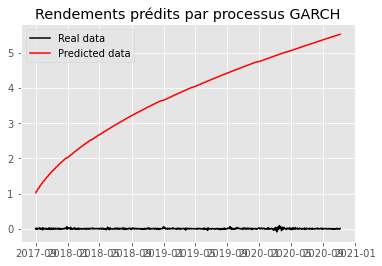

In [13]:
serie.garch_modelisation(5,5)

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## III- Bootstrapping <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

On réalise un bootstrapping sur les rendements de notre série de données. Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set.

On calcule sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

Date
2017-08-31   -0.003658
2017-09-01   -0.000847
2017-09-04   -0.000372
2017-09-05   -0.001156
2017-09-06   -0.003076
                ...   
2020-11-02   -0.001213
2020-11-03   -0.001709
2020-11-04   -0.000931
2020-11-05   -0.001762
2020-11-06   -0.000690
Length: 810, dtype: float64

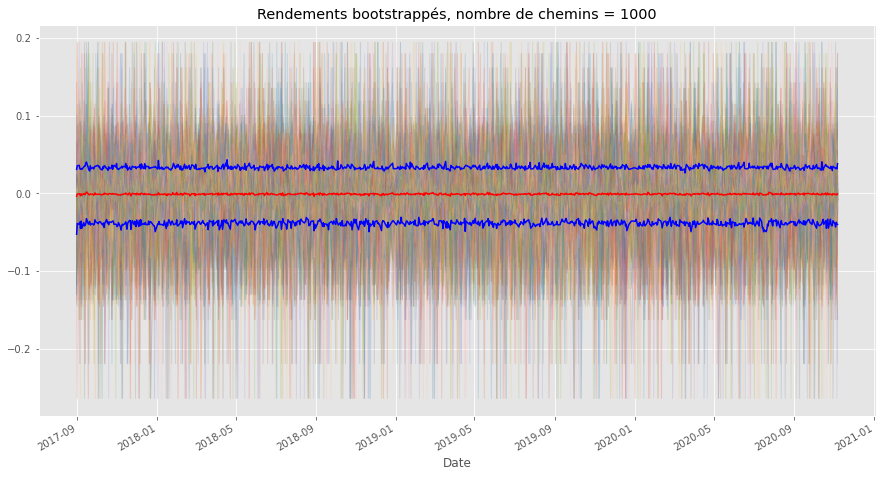

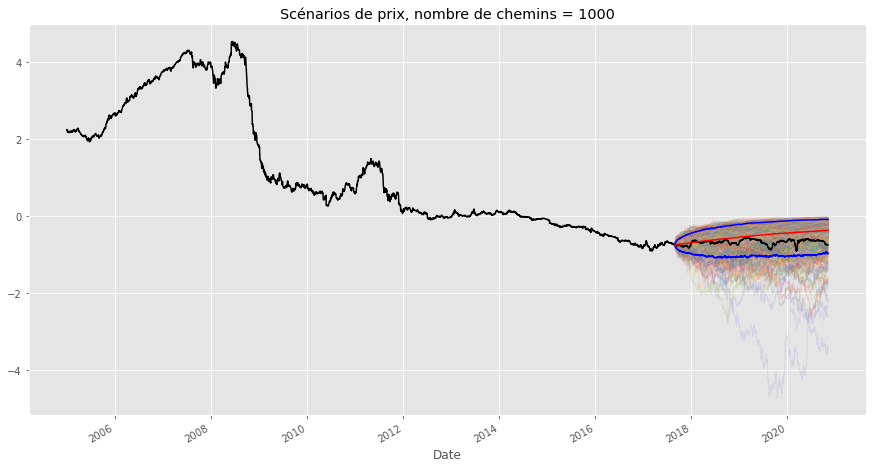

In [14]:
serie.historical_simulation(1000)

## IV - Filtred Historical Simulation <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

<u><strong> Etape 1 :</strong> Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser </u>

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

<u><strong> Etape 2 : </strong> Standardisation des rendements </u>

<u><strong>Etape 3 :</strong> Bootstrapping à partir des rendements standardisés </u>

Date
2005-01-04    1.755699
2005-01-05    1.686070
2005-01-06    1.706440
2005-01-07    2.098520
2005-01-10    2.032705
                ...   
2017-08-23    1.129184
2017-08-24    1.191667
2017-08-25    1.137887
2017-08-28    1.103487
2017-08-29    1.078918
Name: cond_vol, Length: 3239, dtype: float64


Date
2017-08-31   -0.000743
2017-09-01   -0.000182
2017-09-04   -0.000221
2017-09-05   -0.000337
2017-09-06    0.000246
                ...   
2020-11-02    0.000070
2020-11-03   -0.000142
2020-11-04   -0.000293
2020-11-05   -0.000394
2020-11-06    0.000027
Length: 810, dtype: float64

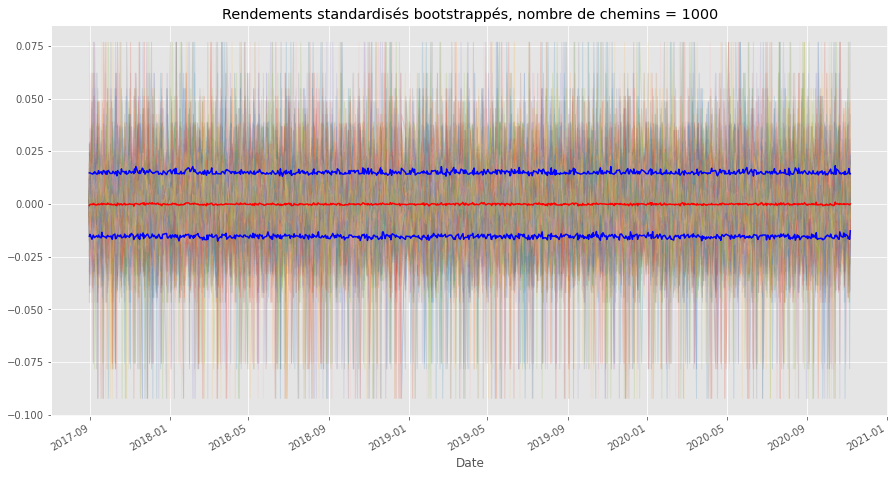

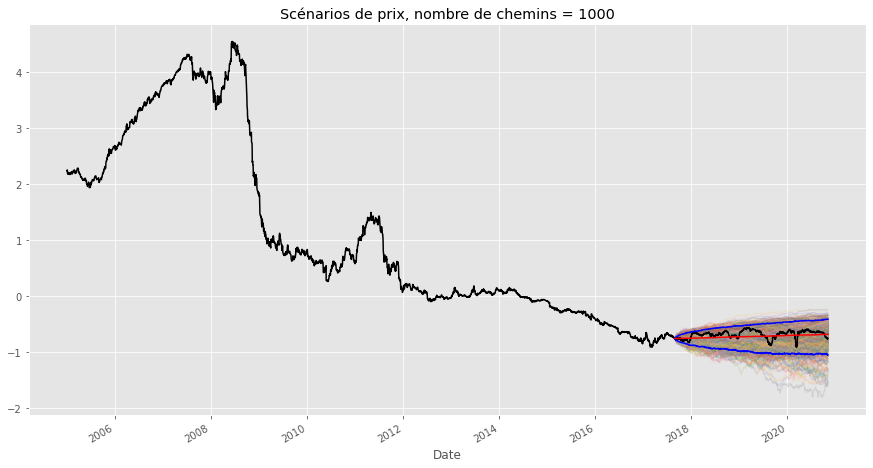

In [37]:
serie.filtered_historical_simulation_GARCH(1000)

##### Complément : FHS utilisant la fenêtre glissante

Date
2017-08-31    0.000476
2017-09-01   -0.000353
2017-09-04   -0.000399
2017-09-05   -0.000345
2017-09-06   -0.000006
                ...   
2020-11-02   -0.000269
2020-11-03   -0.000237
2020-11-04    0.000297
2020-11-05    0.000296
2020-11-06    0.000151
Length: 810, dtype: float64

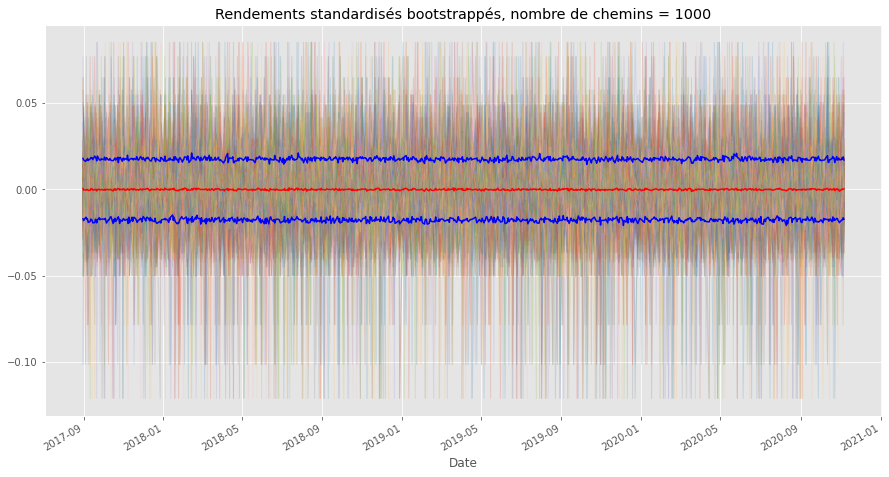

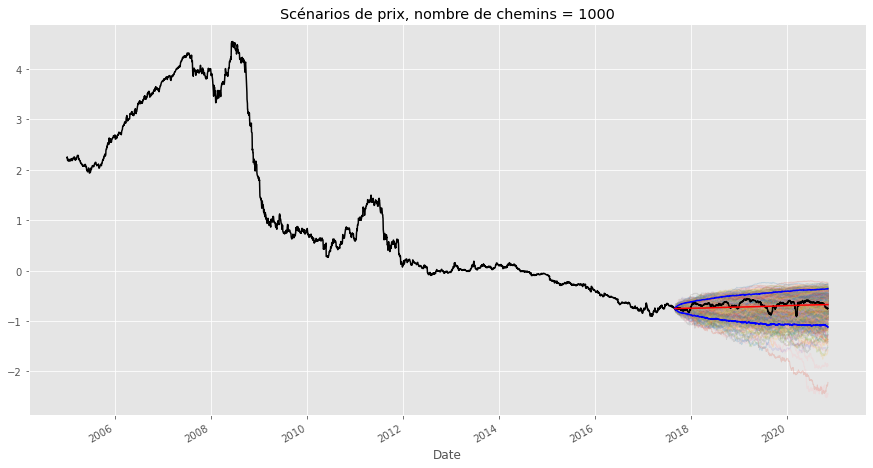

In [148]:
serie.filtered_historical_simulation_glissant(1000,20)

## V - Fonction de performance <a class="anchor" id="chapter5"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

#### V.1 - Fonctions de mesures <a class="anchor" id="chapter5.section1"></a>

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisé de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [16]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [17]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [18]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)


Nous avons ensuite choisi 3 tests permettant de comparer la <u>moyenne et la variance entre deux distributions</u> de fonctions : 

- <strong> Z-test </strong> : Comparaison de la moyenne des distributions
- <strong> (Student) t-test </strong>: Comparaison de la moyenne des distributions
- <strong> F-test </strong>: Comparaison de la variance des distributions

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [19]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from statsmodels.stats.weightstats import ztest

def Z_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [20]:
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def t_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [21]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(data):
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

Nous avons ensuite choisi 3 mesures permettant de  <u>comparer deux distributions </u> de fonctions : 

- <strong> Test de rang de Mann-Whitneyu </strong>
- <strong> Test de rang de Wilcoxon </strong>
- <strong> Distance de Wasserstein </strong>

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [22]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Mann_Whitneyu(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

In [23]:
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wilcoxon(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [24]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)

#### V.2 - Fonction Describe   <a class="anchor" id="chapter5.section2"></a>

[Retour Sommaire](#sommaire)

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés par Historical Simulation
- La moyenne de nos scénarii générés par Filtered Historical Simulation

In [153]:
serie.describe()

,Testing Set,Simulated Data HS,Simulated Data FHS GARCH,Simulated Data FHS glissant
count,810,810.000000,810.000000,810.000000
mean,5.75926e-06,-0.000959,-0.000123,-0.000138
std,0.0129008,0.000823,0.000322,0.000374
min,-0.092068,-0.003480,-0.001019,-0.001603
25%,-0.00668475,-0.001492,-0.000352,-0.000380
50%,-0.0004405,-0.000934,-0.000124,-0.000134
75%,0.005659,-0.000377,0.000106,0.000093
max,0.089003,0.001299,0.000919,0.001000
Median Absolute Deviation,0.00884703,0.000657,0.000257,0.000294
skew,0.407536,-0.100124,0.096039,-0.018226


#### V.3 - Comparaison des prévisions GARCH(p,q) / Boostraping / FHS   <a class="anchor" id="chapter5.section2"></a>

[Retour Sommaire](#sommaire)